# PROJECT LUNG DISEASES

# REQUIREMENT

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Input, Bidirectional, LSTM, TimeDistributed, RNN, BatchNormalization
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import shutil
import cv2
import os

print ('Library loaded')

Library loaded


# Initiation Directory

In [2]:
# flow_from_directory
train = '/kaggle/input/penyakit-paru-paru-5-kelas/train_dir'
val = '/kaggle/input/penyakit-paru-paru-5-kelas/test_dir'

# Datagenerator

In [3]:
# Membuat objek ImageDataGenerator untuk augmentasi data pada set pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255
)

# Membuat objek ImageDataGenerator untuk preprocessing pada set pengujian dan validasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan objek ImageDataGenerator untuk memuat data gambar dari direktori dan melakukan augmentasi
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(224, 224),
    class_mode='categorical',  # Mode kelas untuk klasifikasi banyak kelas
    batch_size = 16,
    shuffle= True
)

val_generator = test_val_datagen.flow_from_directory(
    val,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size = 16
)
batch_size=16
image_size = 224

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


## TRAINNING W RESNET50

In [4]:
base_model_resnet50 = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_resnet50.layers:
    layer.trainable = False
    
model_resnet50 = Sequential()
model_resnet50.add(base_model_resnet50)
model_resnet50.add(TimeDistributed(Flatten()))
model_resnet50.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_resnet50.add(Dropout(0.2))
model_resnet50.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model_resnet50.add(Dropout(0.2))
model_resnet50.add(Dense(32, activation="relu"))
model_resnet50.add(Dense(32, activation="relu"))
model_resnet50.add(Dense(5, activation="softmax"))

model_resnet50.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 14336)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 7, 256)            14812160  
_________________________________________________________________
dropout (Dropout)            (None, 7, 256)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________

In [5]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_resnet50.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=1e-6,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
)

history_resnet50 = model_resnet50.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25, 
    verbose=1, 
    callbacks=[reduce_lr, 
               early_stopping]
)

Epoch 1/25
380/380 [==============================] - 81s 170ms/step - loss: 1.6123 - acc: 0.2030 - val_loss: 1.6105 - val_acc: 0.2281
Epoch 2/25
380/380 [==============================] - 34s 89ms/step - loss: 1.5643 - acc: 0.2597 - val_loss: 1.3863 - val_acc: 0.2811
Epoch 3/25
380/380 [==============================] - 34s 90ms/step - loss: 1.3294 - acc: 0.3786 - val_loss: 1.0745 - val_acc: 0.4807
Epoch 4/25
380/380 [==============================] - 35s 91ms/step - loss: 1.2196 - acc: 0.4441 - val_loss: 1.0233 - val_acc: 0.5804
Epoch 5/25
380/380 [==============================] - 35s 91ms/step - loss: 1.1378 - acc: 0.4855 - val_loss: 1.0204 - val_acc: 0.5092
Epoch 6/25
380/380 [==============================] - 35s 92ms/step - loss: 1.1208 - acc: 0.5041 - val_loss: 0.9174 - val_acc: 0.5988
Epoch 7/25
380/380 [==============================] - 34s 90ms/step - loss: 1.0599 - acc: 0.5373 - val_loss: 0.8968 - val_acc: 0.6212
Epoch 8/25
380/380 [==============================] - 34s 89m

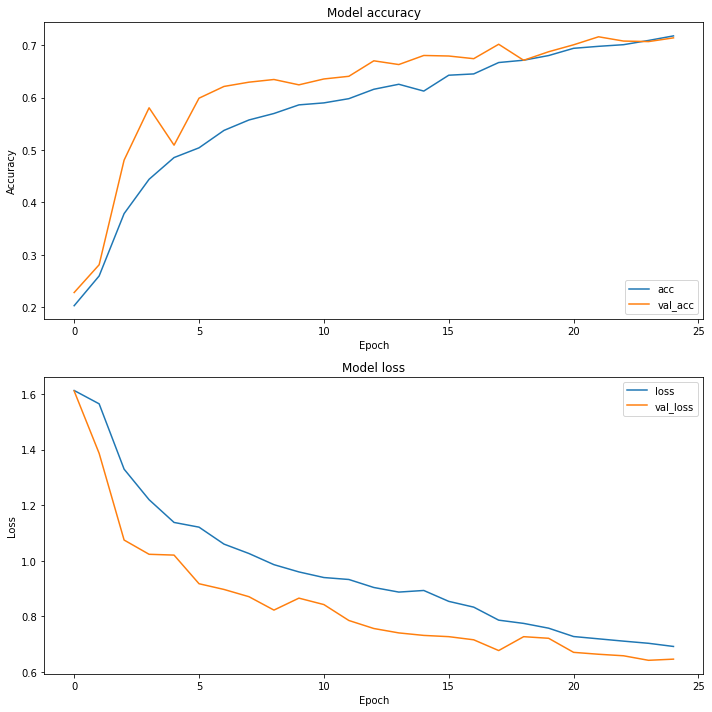

In [6]:
plt.figure(figsize=(10,10))
# Plot grafik akurasi
plt.subplot(2, 1, 1)
plt.plot(history_resnet50.history["acc"])
plt.plot(history_resnet50.history["val_acc"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["acc", "val_acc"], loc="lower right")

# Plot grafik loss
plt.subplot(2, 1, 2)
plt.plot(history_resnet50.history["loss"])
plt.plot(history_resnet50.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss", "val_loss"], loc="upper right")

plt.tight_layout()  # Agar grafik tidak tumpang tindih
plt.show()


In [7]:
train_score = model_resnet50.evaluate(train_generator, verbose=1)
test_score = model_resnet50.evaluate(val_generator, verbose=1)

62/62 [==============================] - 5s 81ms/step - loss: 0.6462 - acc: 0.7138


Found 982 images belonging to 5 classes.
62/62 [==============================] - 7s 81ms/step

Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.21827   0.20874   0.21340       206
            covid19    0.21138   0.24645   0.22757       211
             normal    0.25490   0.18660   0.21547       209
       tuberculosis    0.17763   0.19286   0.18493       140
    viral_pneumonia    0.17521   0.18981   0.18222       216

           accuracy                        0.20570       982
          macro avg    0.20748   0.20489   0.20472       982
       weighted avg    0.20932   0.20570   0.20597       982



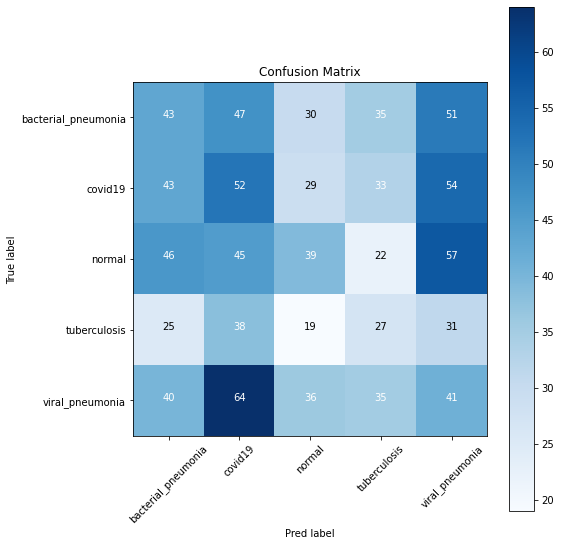

In [8]:
y_true = np.array([])
for i in range(len(val_generator)):
    batch = next(val_generator)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(val_generator.class_indices.keys())

test_all_batches = test_val_datagen.flow_from_directory(
    directory=val,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = val_generator.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_resnet50.predict(val_generator, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_generator.class_indices, digits=5
)
print("\nClassification Report:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

Found 6080 images belonging to 5 classes.
380/380 [==============================] - 28s 74ms/step

Training Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.72081   0.69836   0.70941      1220
            covid19    0.67907   0.77796   0.72516      1243
             normal    0.83931   0.54980   0.66438      1235
       tuberculosis    0.74507   0.90427   0.81699      1170
    viral_pneumonia    0.66104   0.67904   0.66992      1212

           accuracy                        0.72023      6080
          macro avg    0.72906   0.72189   0.71717      6080
       weighted avg    0.72910   0.72023   0.71631      6080



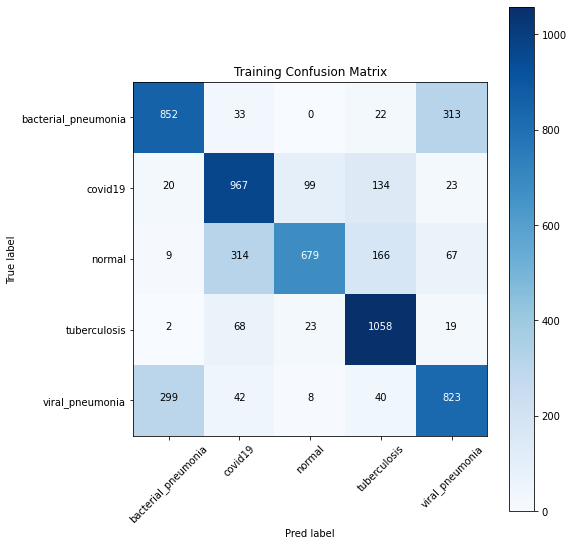

In [9]:
y_true = np.array([])
for i in range(len(train_generator)):
    batch = next(train_generator)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_generator.class_indices.keys())

train_all_batches = train_datagen.flow_from_directory(
    directory=train,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_resnet50.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W VGG19


### Load Pretrained CNN

In [10]:
base_model_vgg19 = tf.keras.applications.VGG19(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_vgg19.layers:
    layer.trainable = False

model_vgg19 = Sequential()
model_vgg19.add(base_model_vgg19)
model_vgg19.add(TimeDistributed(Flatten()))
model_vgg19.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_vgg19.add(Dropout(0.5))
model_vgg19.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model_vgg19.add(Dropout(0.5))
model_vgg19.add(Dense(32, activation="relu"))
model_vgg19.add(Dense(32, activation="relu"))
model_vgg19.add(Dense(5, activation="softmax"))

model_vgg19.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 3584)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 7, 256)            3802112   
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 256)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_______________________________________________________

In [12]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_vgg19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=1e-6,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
)

history_vgg19 = model_vgg19.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25, 
    verbose=1, 
    callbacks=[reduce_lr, 
               early_stopping]
)

Epoch 1/25
380/380 [==============================] - 52s 112ms/step - loss: 1.2109 - acc: 0.4569 - val_loss: 0.6862 - val_acc: 0.7322
Epoch 2/25
380/380 [==============================] - 38s 100ms/step - loss: 0.7270 - acc: 0.7066 - val_loss: 0.5116 - val_acc: 0.7953
Epoch 3/25
380/380 [==============================] - 39s 102ms/step - loss: 0.5892 - acc: 0.7622 - val_loss: 0.5336 - val_acc: 0.7862
Epoch 4/25
380/380 [==============================] - 38s 101ms/step - loss: 0.5277 - acc: 0.7888 - val_loss: 0.4617 - val_acc: 0.8238
Epoch 5/25
380/380 [==============================] - 39s 101ms/step - loss: 0.4856 - acc: 0.8076 - val_loss: 0.3962 - val_acc: 0.8432
Epoch 6/25
380/380 [==============================] - 38s 101ms/step - loss: 0.4443 - acc: 0.8250 - val_loss: 0.4763 - val_acc: 0.8259
Epoch 7/25
380/380 [==============================] - 38s 101ms/step - loss: 0.4204 - acc: 0.8340 - val_loss: 0.3511 - val_acc: 0.8707
Epoch 8/25
380/380 [==============================] - 3

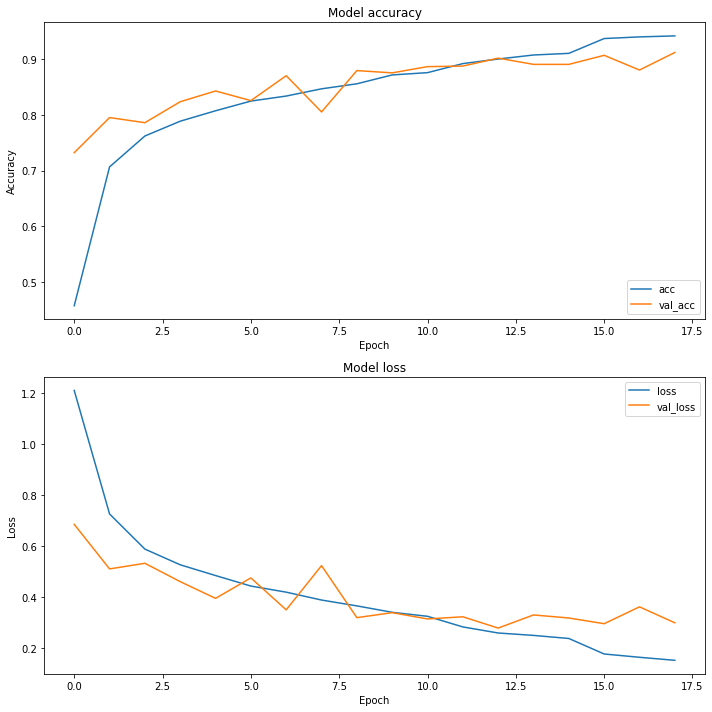

In [14]:
plt.figure(figsize=(10,10))
# Plot grafik akurasi
plt.subplot(2, 1, 1)
plt.plot(history_vgg19.history["acc"])
plt.plot(history_vgg19.history["val_acc"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["acc", "val_acc"], loc="lower right")

# Plot grafik loss
plt.subplot(2, 1, 2)
plt.plot(history_vgg19.history["loss"])
plt.plot(history_vgg19.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss", "val_loss"], loc="upper right")

plt.tight_layout()  # Agar grafik tidak tumpang tindih
plt.show()


In [15]:
train_score = model_vgg19.evaluate(train_generator, verbose=1)
test_score = model_vgg19.evaluate(val_generator, verbose=1)

62/62 [==============================] - 5s 86ms/step - loss: 0.2797 - acc: 0.9022


Found 982 images belonging to 5 classes.
62/62 [==============================] - 7s 86ms/step

Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.21495   0.22330   0.21905       206
            covid19    0.19431   0.19431   0.19431       211
             normal    0.20388   0.20096   0.20241       209
       tuberculosis    0.12143   0.12143   0.12143       140
    viral_pneumonia    0.22275   0.21759   0.22014       216

           accuracy                        0.19654       982
          macro avg    0.19147   0.19152   0.19147       982
       weighted avg    0.19654   0.19654   0.19652       982



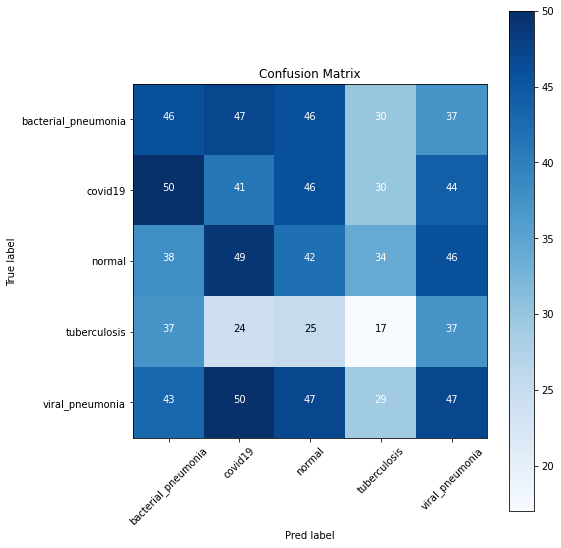

In [16]:
y_true = np.array([])
for i in range(len(val_generator)):
    batch = next(val_generator)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(val_generator.class_indices.keys())

test_all_batches = test_val_datagen.flow_from_directory(
    directory=val,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = val_generator.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_vgg19.predict(val_generator, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_generator.class_indices, digits=5
)
print("\nClassification Report:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

Found 6080 images belonging to 5 classes.
380/380 [==============================] - 36s 94ms/step

Training Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.91359   0.89262   0.90299      1220
            covid19    0.96000   0.94610   0.95300      1243
             normal    0.94188   0.95789   0.94982      1235
       tuberculosis    0.98546   0.98462   0.98504      1170
    viral_pneumonia    0.88530   0.90429   0.89469      1212

           accuracy                        0.93684      6080
          macro avg    0.93725   0.93710   0.93711      6080
       weighted avg    0.93701   0.93684   0.93686      6080



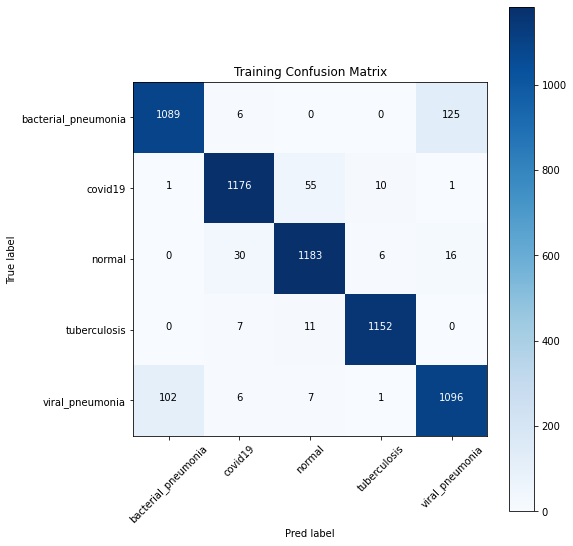

In [17]:
y_true = np.array([])
for i in range(len(train_generator)):
    batch = next(train_generator)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_generator.class_indices.keys())

train_all_batches = train_datagen.flow_from_directory(
    directory=train,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_vgg19.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W InceptionV3


In [18]:
base_model_inceptionv3 = tf.keras.applications.InceptionV3(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_inceptionv3.layers:
    layer.trainable = False

model_inceptionv3 = Sequential()
model_inceptionv3.add(base_model_inceptionv3)
model_inceptionv3.add(TimeDistributed(Flatten()))
model_inceptionv3.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_inceptionv3.add(Dropout(0.5))
model_inceptionv3.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model_inceptionv3.add(Dropout(0.5))
model_inceptionv3.add(Dense(32, activation="relu"))
model_inceptionv3.add(Dense(32, activation="relu"))
model_inceptionv3.add(Dense(5, activation="softmax"))

model_inceptionv3.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 10240)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 5, 256)            10617856  
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 256)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_______________________________________________________

In [19]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_inceptionv3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=1e-6,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
)

history_inceptionv3 = model_inceptionv3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25, 
    verbose=1, 
    callbacks=[reduce_lr, 
               early_stopping]
)

Epoch 1/25
380/380 [==============================] - 44s 91ms/step - loss: 1.0150 - acc: 0.5622 - val_loss: 0.7089 - val_acc: 0.6833
Epoch 2/25
380/380 [==============================] - 31s 81ms/step - loss: 0.7015 - acc: 0.7005 - val_loss: 0.6044 - val_acc: 0.7128
Epoch 3/25
380/380 [==============================] - 31s 82ms/step - loss: 0.6100 - acc: 0.7470 - val_loss: 0.5736 - val_acc: 0.7760
Epoch 4/25
380/380 [==============================] - 31s 81ms/step - loss: 0.5383 - acc: 0.7770 - val_loss: 0.5092 - val_acc: 0.7923
Epoch 5/25
380/380 [==============================] - 30s 80ms/step - loss: 0.4785 - acc: 0.8067 - val_loss: 0.6070 - val_acc: 0.7495
Epoch 6/25
380/380 [==============================] - 31s 81ms/step - loss: 0.4270 - acc: 0.8278 - val_loss: 0.5031 - val_acc: 0.8086
Epoch 7/25
380/380 [==============================] - 32s 83ms/step - loss: 0.3748 - acc: 0.8507 - val_loss: 0.4276 - val_acc: 0.8289
Epoch 8/25
380/380 [==============================] - 31s 81ms

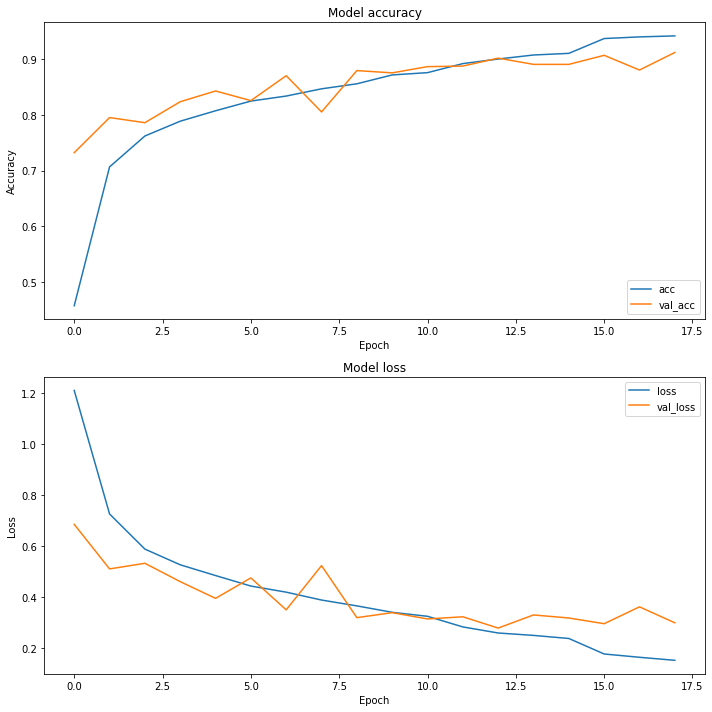

In [20]:
plt.figure(figsize=(10,10))
# Plot grafik akurasi
plt.subplot(2, 1, 1)
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["acc", "val_acc"], loc="lower right")

# Plot grafik loss
plt.subplot(2, 1, 2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss", "val_loss"], loc="upper right")

plt.tight_layout()  # Agar grafik tidak tumpang tindih
plt.show()


In [21]:
train_score = model_inceptionv3.evaluate(train_generator, verbose=1)
test_score = model_inceptionv3.evaluate(val_generator, verbose=1)

62/62 [==============================] - 5s 83ms/step - loss: 0.4276 - acc: 0.8289


Found 982 images belonging to 5 classes.
62/62 [==============================] - 7s 79ms/step

Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.22843   0.21845   0.22333       206
            covid19    0.25854   0.25118   0.25481       211
             normal    0.19907   0.20574   0.20235       209
       tuberculosis    0.16031   0.15000   0.15498       140
    viral_pneumonia    0.21030   0.22685   0.21826       216

           accuracy                        0.21487       982
          macro avg    0.21133   0.21044   0.21075       982
       weighted avg    0.21495   0.21487   0.21477       982



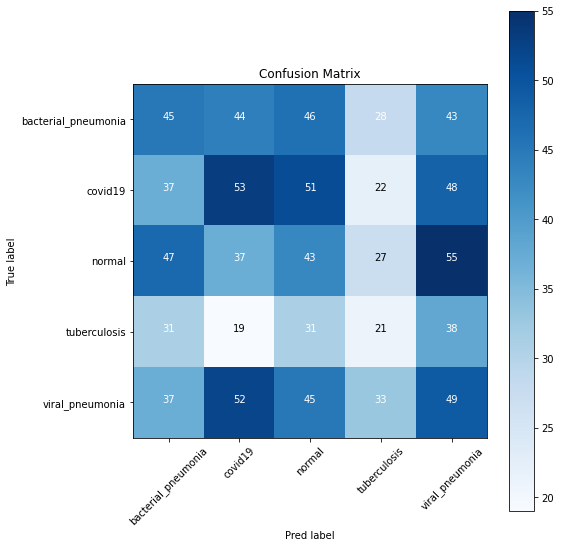

In [22]:
y_true = np.array([])
for i in range(len(val_generator)):
    batch = next(val_generator)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(val_generator.class_indices.keys())

test_all_batches = test_val_datagen.flow_from_directory(
    directory=val,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = val_generator.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_inceptionv3.predict(val_generator, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_generator.class_indices, digits=5
)
print("\nClassification Report:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

Found 6080 images belonging to 5 classes.
380/380 [==============================] - 26s 69ms/step

Training Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.86404   0.80738   0.83475      1220
            covid19    0.97619   0.92357   0.94915      1243
             normal    0.92314   0.96275   0.94253      1235
       tuberculosis    0.99306   0.97778   0.98536      1170
    viral_pneumonia    0.79758   0.87129   0.83281      1212

           accuracy                        0.90822      6080
          macro avg    0.91080   0.90855   0.90892      6080
       weighted avg    0.91055   0.90822   0.90863      6080



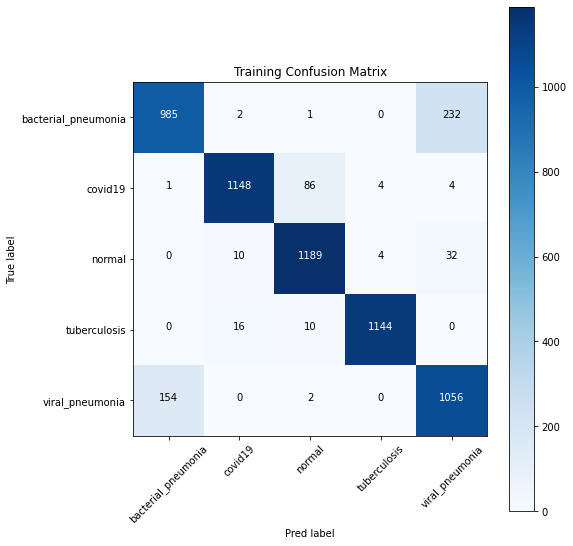

In [23]:
y_true = np.array([])
for i in range(len(train_generator)):
    batch = next(train_generator)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_generator.class_indices.keys())

train_all_batches = train_datagen.flow_from_directory(
    directory=train,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_inceptionv3.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()